### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim

sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data

import matplotlib.pyplot as plt
HUNGRY_DECONV = np.load('../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)
print(HUNGRY_DECONV.shape)

FOOD_RESTRICTED_HUNGRY = [1,2,3,6,7,9,11,12]
CONTROL_HUNGRY = [0,4,5,8,10,13]


AngStim_data = '../Data/metadata_deconv/stimAngle_hungry.mat'
ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells= True)
HUNGRY_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
print(HUNGRY_ANGLE[0].shape)

SfStim_data = '../Data/metadata_deconv/stimSpatFreq_hungry.mat'
SF_STIM_DATA = loadmat(SfStim_data, simplify_cells= True)
HUNGRY_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']
print(HUNGRY_SF[0].shape)

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



(14, 60)
(12, 55)
(55,)
450560


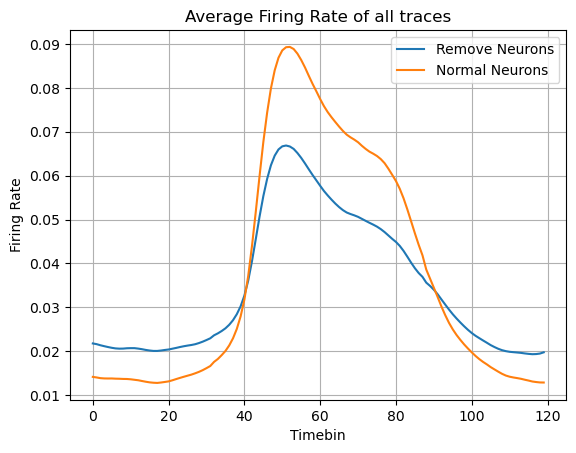

In [4]:
remove_mean = np.zeros((14,120))
normal_mean = np.zeros((14,120))
for i in range(14):
    remove_mean[i,:] = np.nanmean(resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
    normal_mean[i,:] = np.nanmean(remove_neurons(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
plt.plot(np.mean(remove_mean,axis=0), label = 'Remove Neurons')
plt.plot(np.mean(normal_mean,axis=0), label = 'Normal Neurons')
plt.xlabel('Timebin')
plt.ylabel('Firing Rate')
plt.title('Average Firing Rate of all traces')
plt.legend()
plt.grid()

In [3]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)[:,:,1,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)

N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

(11, 12, 128)


In [4]:
hyperparams = {
    'sigma_m': 0.5,
    'gamma_gp': 1e-5,
    'beta_gp': 10.0,
    'sigma_c': 0.5,
    'gamma_wp': 1e-6,
    'beta_wp': 1.0,
    'p': N+1
    }

In [5]:
# Initialise Kernel and Model
periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)


Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [6]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 10000,key=key)
joint.update_params(varfam.posterior)

E0509 11:04:38.390104   13139 buffer_comparator.cc:156] Difference at 192: 0, expected 29.5135
E0509 11:04:38.390137   13139 buffer_comparator.cc:156] Difference at 193: 0, expected 33.1421
E0509 11:04:38.390141   13139 buffer_comparator.cc:156] Difference at 194: 0, expected 37.7762
E0509 11:04:38.390143   13139 buffer_comparator.cc:156] Difference at 195: 0, expected 33.5764
E0509 11:04:38.390146   13139 buffer_comparator.cc:156] Difference at 196: 0, expected 30.7878
E0509 11:04:38.390148   13139 buffer_comparator.cc:156] Difference at 197: 0, expected 30.9412
E0509 11:04:38.390150   13139 buffer_comparator.cc:156] Difference at 198: 0, expected 30.266
E0509 11:04:38.390152   13139 buffer_comparator.cc:156] Difference at 199: 0, expected 33.7627
E0509 11:04:38.390155   13139 buffer_comparator.cc:156] Difference at 200: 0, expected 36.2597
E0509 11:04:38.390157   13139 buffer_comparator.cc:156] Difference at 201: 0, expected 35.1717
2025-05-09 11:04:38.390165: E external/xla/xla/serv

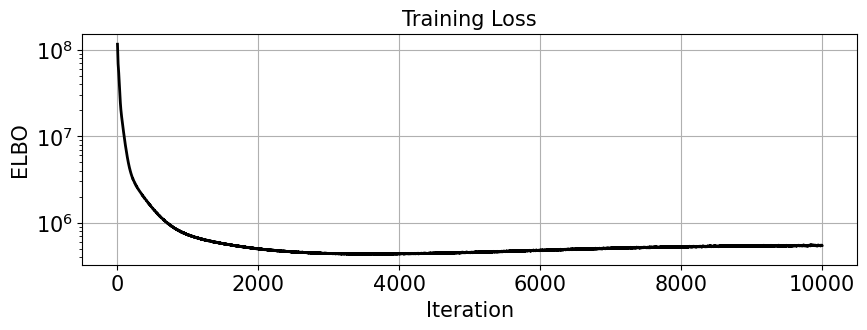

In [7]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

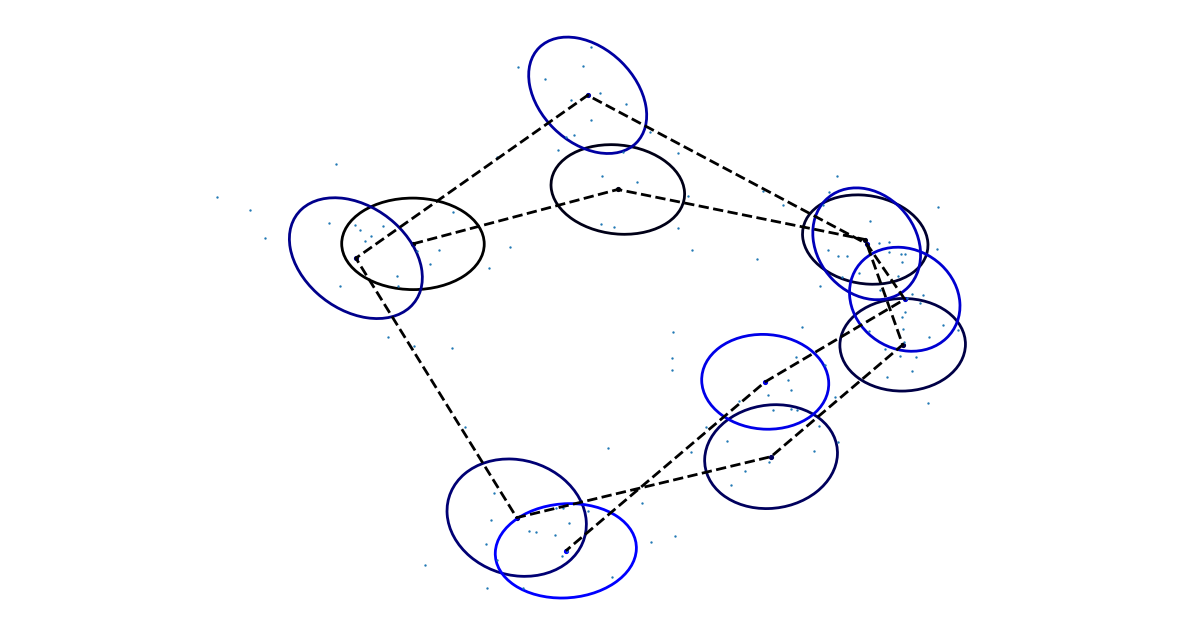

In [9]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


# Hyper Param Tuning

In [24]:
def evaluate_hyperparameters(hyperparams, x_train, y_train, x_test, y_test, n_iter=5000):

    # Initialize kernels with the hyperparameters
    periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
    periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))
    
    # Set up the model
    gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
    wp = models.WishartProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-2*jnp.eye(N), optimize_L=False)
    likelihood = models.NormalConditionalLikelihood(N)
    joint = models.JointGaussianWishartProcess(gp, wp, likelihood)
    
    # Set up variational inference
    inference_seed = 2
    key = jax.random.PRNGKey(inference_seed)
    varfam = inference.VariationalNormal(joint.model)
    adam = optim.Adam(1e-1)
    
    # Train the model
    varfam.infer(adam, x_train, y_train, n_iter=n_iter, key=key)
    joint.update_params(varfam.posterior)
    
    posterior = models.NormalGaussianWishartPosterior(joint,varfam,x_train)
    with numpyro.handlers.seed(rng_seed=inference_seed):
        mu_hat, sigma_hat, F_hat = posterior.sample(x_train)
    mu_empirical = y_train.mean(0)
    log_likelihood = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()

    # # Create posterior and compute log likelihood on validation data
    # posterior = models.NormalGaussianWishartPosterior(joint, varfam, x_train)
    # Compute log likelihood (directly using the posterior's log_prob method)
    # This uses x_val and y_val_data
    # log_likelihood = posterior.log_prob(x_test, y_test['x'])

    return log_likelihood.mean()

def optimize_hyperparameters(x_train, y_train, x_val, y_val, hyperparam_grid, n_iter=5000):
    
    # Generate all combinations of hyperparameters
    keys = list(hyperparam_grid.keys())
    values = list(hyperparam_grid.values())
    hyperparameter_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
        
    best_score = float('-inf')  # For log-likelihood, higher is better
    best_hyperparams = None
    
    for i, hyperparams in enumerate(tqdm(hyperparameter_combinations)):
        try:
            print(f"\nEvaluating hyperparameters {i+1}/{len(hyperparameter_combinations)}:")
            score = evaluate_hyperparameters(hyperparams, x_train, y_train, x_val, y_val, n_iter)
            
            print(f"Score: {score}")
            
            # Update best if needed
            if score > best_score:
                best_score = score
                best_hyperparams = hyperparams
                print(f"New best score: {best_score}")
                
        except Exception as e:
            print(f"Error with hyperparams {hyperparams}: {str(e)}")
            continue
    
    return best_hyperparams, best_score

# Main execution
if __name__ == "__main__":
    # Split data
    data = utils.split_data(x=X_CONDITIONS[:, None], y=TEST_RESPONSE, 
                           train_trial_prop=0.8, train_condition_prop=0.8, seed=SEED)
    x_train, y_train, _, _, x_test, y_test, _, _, _, _, _, _, _, _ = data
    
    print('x conditions train ', x_train.shape)     # x_train 80% of conditions: 9/12

    print('y data train ', y_train.shape)     # ytrain 80% conditions and trials : 9/12, 8/11

    print('x conditions val ', x_test.shape)     # x_test 20% of conditions: 3/12

    print('y_val, (x) ', y_test['x'].shape)     # y_test['x'] 20% of trials and 80% conditions: 9/12, 3/11

    print('y_val, (x_test) ', y_test['x_test'].shape)     # y_test['x_test'] 100% of trials and 20% conditions: 3/12, 11/11
    x_train = x_train.reshape(x_train.shape[0])
    x_test = x_test.reshape(x_test.shape[0])

    # Define a more focused hyperparameter grid
    hyperparam_grid = {
        'sigma_m': [0.1, 0.5, 1.0,5,10],
        'gamma_gp': [1e-5],
        'beta_gp': [1e1],
        'sigma_c': [0.1, 0.5, 1.0,5,10],
        'gamma_wp': [1e-6],
        'beta_wp': [1],
        'p': [N+1]
    }
    
    # Run optimization with a time budget of 12 hours
    best_hyperparams, best_score = optimize_hyperparameters(
        x_train, y_train, x_test, y_test, 
        hyperparam_grid, 
        n_iter=4000)
    
    print("\n=== Optimization Results ===")
    print(f"Best hyperparameters:")
    for k, v in best_hyperparams.items():
        print(f"  {k}: {v}")
    print(f"Best score: {best_score}")

x conditions train  (9, 1)
y data train  (8, 9, 128)
x conditions val  (3, 1)
y_val, (x)  (3, 9, 128)
y_val, (x_test)  (11, 3, 128)


  0%|          | 0/25 [00:00<?, ?it/s]


Evaluating hyperparameters 1/25:


  4%|▍         | 1/25 [00:06<02:26,  6.09s/it]

Score: nan

Evaluating hyperparameters 2/25:


  8%|▊         | 2/25 [00:12<02:24,  6.29s/it]

Score: 64.37904357910156
New best score: 64.37904357910156

Evaluating hyperparameters 3/25:


 12%|█▏        | 3/25 [00:18<02:18,  6.31s/it]

Score: -28.27152442932129

Evaluating hyperparameters 4/25:


 16%|█▌        | 4/25 [00:25<02:12,  6.30s/it]

Score: -389.63824462890625

Evaluating hyperparameters 5/25:


 20%|██        | 5/25 [00:31<02:05,  6.28s/it]

Score: -721.4244995117188

Evaluating hyperparameters 6/25:


 24%|██▍       | 6/25 [00:37<02:00,  6.34s/it]

Score: nan

Evaluating hyperparameters 7/25:


 28%|██▊       | 7/25 [00:44<01:55,  6.40s/it]

Score: 66.74087524414062
New best score: 66.74087524414062

Evaluating hyperparameters 8/25:


 32%|███▏      | 8/25 [00:50<01:48,  6.37s/it]

Score: -26.900209426879883

Evaluating hyperparameters 9/25:


 36%|███▌      | 9/25 [00:57<01:41,  6.37s/it]

Score: -389.4669494628906

Evaluating hyperparameters 10/25:


 40%|████      | 10/25 [01:04<01:39,  6.66s/it]

Score: -718.0930786132812

Evaluating hyperparameters 11/25:


 44%|████▍     | 11/25 [01:10<01:32,  6.60s/it]

Score: nan

Evaluating hyperparameters 12/25:


 48%|████▊     | 12/25 [01:17<01:24,  6.52s/it]

Score: 65.10102844238281

Evaluating hyperparameters 13/25:


 52%|█████▏    | 13/25 [01:23<01:17,  6.47s/it]

Score: -29.11460304260254

Evaluating hyperparameters 14/25:


 56%|█████▌    | 14/25 [01:29<01:10,  6.43s/it]

Score: -386.42620849609375

Evaluating hyperparameters 15/25:


 60%|██████    | 15/25 [01:36<01:03,  6.38s/it]

Score: -731.2971801757812

Evaluating hyperparameters 16/25:


 64%|██████▍   | 16/25 [01:42<00:57,  6.38s/it]

Score: nan

Evaluating hyperparameters 17/25:


 68%|██████▊   | 17/25 [01:48<00:50,  6.33s/it]

Score: 9.55447769165039

Evaluating hyperparameters 18/25:


 72%|███████▏  | 18/25 [01:54<00:44,  6.31s/it]

Score: -168.90086364746094

Evaluating hyperparameters 19/25:


 76%|███████▌  | 19/25 [02:01<00:37,  6.30s/it]

Score: -484.1737365722656

Evaluating hyperparameters 20/25:


 80%|████████  | 20/25 [02:07<00:31,  6.29s/it]

Score: -741.7113647460938

Evaluating hyperparameters 21/25:


 84%|████████▍ | 21/25 [02:13<00:25,  6.30s/it]

Score: nan

Evaluating hyperparameters 22/25:


 88%|████████▊ | 22/25 [02:20<00:18,  6.26s/it]

Score: 13.682110786437988

Evaluating hyperparameters 23/25:


 92%|█████████▏| 23/25 [02:26<00:12,  6.21s/it]

Score: -195.8194580078125

Evaluating hyperparameters 24/25:


 96%|█████████▌| 24/25 [02:32<00:06,  6.20s/it]

Score: -497.22845458984375

Evaluating hyperparameters 25/25:


100%|██████████| 25/25 [02:38<00:00,  6.34s/it]

Score: -710.4261474609375

=== Optimization Results ===
Best hyperparameters:
  sigma_m: 0.5
  gamma_gp: 1e-05
  beta_gp: 10.0
  sigma_c: 0.5
  gamma_wp: 1e-06
  beta_wp: 1
  p: 129
Best score: 66.74087524414062


In [ ]:
Optimize L or not
WP lrd?


# Compare to Empirical

(12, 128)
(12, 128, 128)


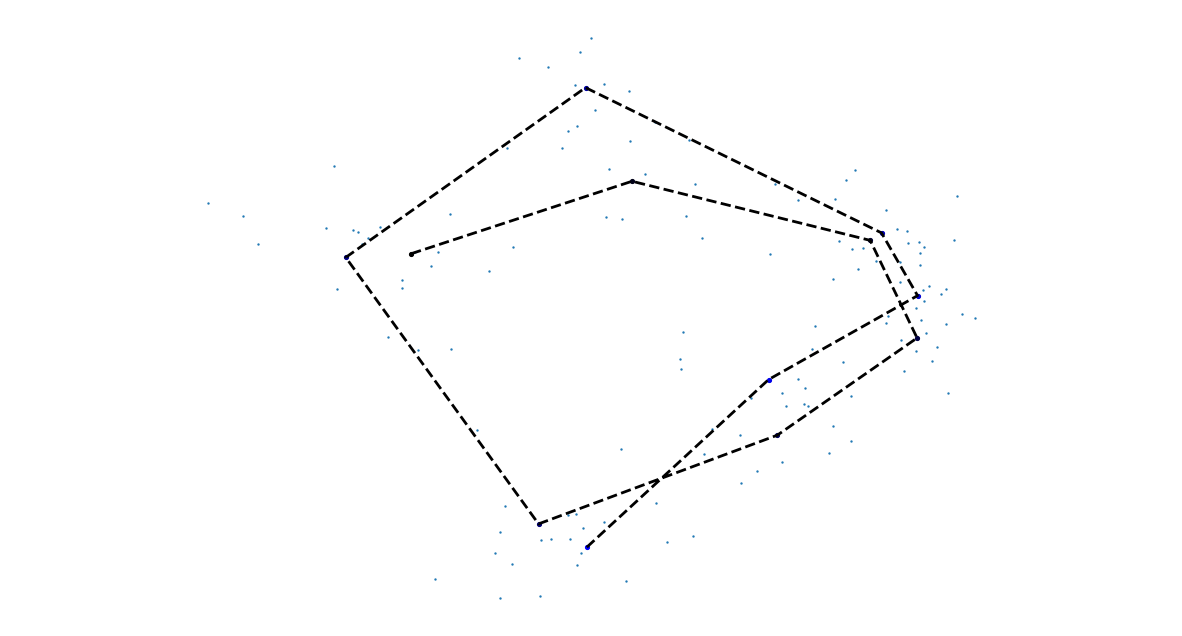

TypeError: object of type 'NoneType' has no len()

In [50]:
#Also Compute empirical mean and covariance

import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    empirical_sigma.at[i].set(covariances)
print(empirical_sigma.shape)

visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)
visualizations.draw_ellipse(empirical_mu[:,None],empirical_sigma,plt.cm.hsv(np.linspace(0,1,len(None)+1)[0:-1])[:,0:3], ax = plt.gca())



# Test Unseen conditions 

In [44]:
# Given
# -----
# X_test : ndarray, (num_test_conditions x num_variables), test data from first network.

# Interpolate covariances in unseen test conditions 
# test at 200 points instead of C
x_test = jnp.linspace(0, C-1, 100)  # shape (200, 1)

with numpyro.handlers.seed(rng_seed=SEED):
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(x_test)

visualizations.visualize_pc(
    mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Next things

In [ ]:
# Evaluate posterior mode
with numpyro.handlers.seed(rng_seed=SEED):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)

# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=SEED):
    mu_prime, sigma_prime = posterior.derivative(x)

# For the Poisson model, compute summary statistics (such as mean firing rate)
with numpyro.handlers.seed(rng_seed=SEED):
    mu_hat = posterior.mean_stat(lambda x: x, x)

In [ ]:
# %%
def fisher_information(x,mu_prime,sigma,sigma_prime=None):
    '''Computing Fisher Information with and without access to the gradient 
    of the covariances wrt the input parameter x
    '''
    tr = lambda x: jnp.diag(x).sum()
    sigma_inv = [np.linalg.inv(sigma[i]) for i in range(len(x))]
    
    fi = [mu_prime[:,[i]].T@sigma_inv[i]@mu_prime[:,[i]] for i in range(len(x))]
    if sigma_prime is not None:
        fi = [fi[i] + .5*tr((sigma_inv[i]@sigma_prime[i])**2) for i in range(len(x))]
    
    return np.array(fi)
# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=SEED):
    mu_prime, sigma_prime = posterior.derivative(x)

In [ ]:
def fisher_information_mode(posterior, x, constant_cov: bool = False):
    """
    Compute Fisher Information at each row of x, using the posterior mode and its derivative.

    Args:
      posterior     : fitted posterior with .mode(x) → (mu, sigma, _)
                      and .derivative(x) → (mu_prime, sigma_prime)
      x             : [M, D] array of test inputs
      constant_cov  : if True, drop the covariance‐gradient term

    Returns:
      fi            : [M] array of FI(x) at each test input
    """
    # 1) get posterior mode and its derivative
    mu_hat,   sigma_hat, _   = posterior.mode(x)        # mu_hat: [M, L], sigma_hat: [M, L, L]
    mu_prime, sigma_prime    = posterior.derivative(x)  # mu_prime: [M, L], sigma_prime: [M, L, L]

    # 2) invert each Sigma(x)
    inv_sigma = jnp.linalg.inv(sigma_hat)               # [M, L, L]

    # 3) define FI for a single input
    def fi_per_point(mu_p, sig_p, inv_sig, mu_h):
        # term1 = μ'ᵀ Σ^{-1} μ'
        t1 = mu_p @ (inv_sig @ mu_p)

        if constant_cov:
            return t1

        # term2 = ½ tr[(Σ^{-1} Σ')²]
        A  = inv_sig @ sig_p
        t2 = 0.5 * jnp.trace(A @ A)
        return t1 + t2

    # 4) vectorize over the M test points
    fi = jax.vmap(fi_per_point, in_axes=(0, 0, 0, 0))(
        mu_prime, sigma_prime, inv_sigma, mu_hat
    )  # → [M]

    return fi


# x_test is your [M x D] grid of new conditions
fi_vals = fisher_information_mode(posterior, x_test, constant_cov=False)
print("Fisher Information at test points:", fi_vals)